# Tracking ice floes in a series of binary images

In this example, we show how to use individual functions in the IceFloeTracker package to extract features from a sequence of binary images, prepare the property tables for each image to include the information needed for the tracker, and then run the tracker.

To start out, we need to activate the project and import the libraries we'll be using. The first time you run this notebook, you may need to use `Pkg.add()` to install libraries and then use `Pkg.resolve()` and `Pkg.instantiate()` to ready the libraries for use.

In [ ]:
using Pkg
using IceFloeTracker: Watkins2025GitHub
using Images: erode, segment_mean, labels_map, SegmentedImage, RGB, mosaicview
import Pkg; Pkg.add("Plots")
using Plots
using IceFloeTracker
using DataFrames
using Images
using CSV

# Loading data

The validation dataset contains manually labeled ice floes for selected images. To test out the tracker, we can use these directly rather than running segmentation steps first.

In [219]:

data_loader = Watkins2025GitHub(; ref="a451cd5e62a10309a9640fbbe6b32a236fcebc70")
dataset = data_loader(c-> c.case_number == 63)
cases = [x for x in dataset.data]
if occursin("terra", cases[1].name)
    terra = cases[1]
    aqua = cases[2]
else
    aqua = cases[1]
    terra = cases[2]
end

┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse /Users/dwatkin2/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


ValidationDataCase("063-beaufort_sea-100km-20070711-terra-250m", Dict{Symbol, Any}(:sea_ice_fraction => 1.0, :visible_floes => "yes", :visible_landfast_ice => "no", :region => "beaufort_sea", :cloud_category_manual => "scattered", :qa_reviewer => "minki", :center_x => -1562500, :modis_cloud_error => "", :start_date => Date("2007-07-11"), :satellite => "terra"…), RGBA{N0f8}[RGBA{N0f8}(0.725,0.776,0.8,1.0) RGBA{N0f8}(0.745,0.8,0.812,1.0) … RGBA{N0f8}(0.741,0.78,0.816,1.0) RGBA{N0f8}(0.667,0.706,0.741,1.0); RGBA{N0f8}(0.733,0.788,0.8,1.0) RGBA{N0f8}(0.745,0.788,0.804,1.0) … RGBA{N0f8}(0.78,0.816,0.843,1.0) RGBA{N0f8}(0.718,0.753,0.78,1.0); … ; RGBA{N0f8}(0.745,0.788,0.804,1.0) RGBA{N0f8}(0.741,0.792,0.816,1.0) … RGBA{N0f8}(0.769,0.812,0.82,1.0) RGBA{N0f8}(0.769,0.812,0.82,1.0); RGBA{N0f8}(0.737,0.78,0.796,1.0) RGBA{N0f8}(0.725,0.776,0.8,1.0) … RGBA{N0f8}(0.765,0.808,0.816,1.0) RGBA{N0f8}(0.765,0.808,0.816,1.0)], RGBA{N0f8}[RGBA{N0f8}(0.0,0.718,0.749,1.0) RGBA{N0f8}(0.0,0.776,0.796,1.0) … 

# Visualize the case
The data include true and falsecolor images from both the Aqua and Terra satellites.

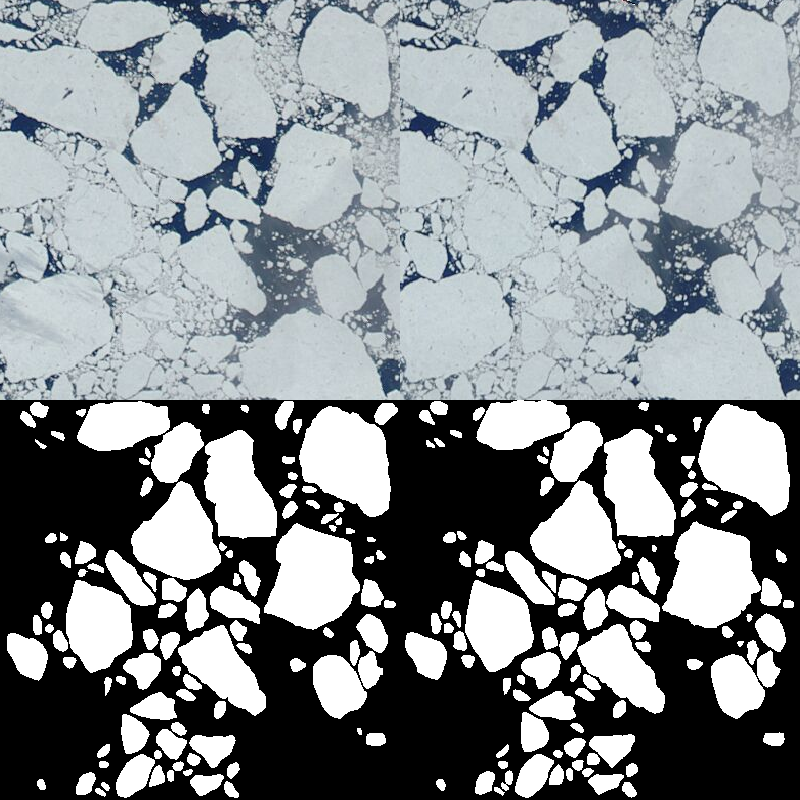

In [220]:
Images.mosaicview(aqua.modis_truecolor, aqua.validated_binary_floes, terra.modis_truecolor, terra.validated_binary_floes, nrow=2)

# Measuring object properties

The example images are binary, so we need to label the connected components before extracting the region properties.

In [221]:
# Set thresholds from file
mc_thresholds = IceFloeTracker.mc_thresholds

# Alternatively load the defaults:
# condition_thresholds = IceFloeTracker.condition_thresholds
ct = (search_thresholds = 
        (dt = (30.0, 100.0, 1300.0),
         dist = (200, 250, 300)),
      small_floe_settings = (minimumarea = 100,
                             arearatio = 0.18,
                             majaxisratio = 0.1,
                             minaxisratio = 0.15,
                             convexarearatio = 0.2),
      large_floe_settings = (minimumarea = 1200,
                             arearatio = 0.28,
                             majaxisratio = 0.1,
                             minaxisratio = 0.12,
                             convexarearatio = 0.14))

# Will be adding overpass time to the metadata soon
passtimes = [DateTime(2019,3,1,0,0), DateTime(2019,3,1,0,15)]

2-element Vector{DateTime}:
 2019-03-01T00:00:00
 2019-03-01T00:15:00

Let's take a look at the property tables:

In [222]:
labeled_images = [terra.validated_labeled_floes.image_indexmap,
                                           aqua.validated_labeled_floes.image_indexmap]
props = IceFloeTracker.regionprops_table.(labeled_images);
props[1]

Row,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length,orientation,perimeter
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,3516.0,1,77,50,170,24,122,3693.0,95.5163,47.8655,-1.38696,252.167
2,204.0,2,31,15,48,9,40,213.0,18.743,13.9108,1.26634,51.799
3,73.0,3,239,11,249,7,244,79.0,10.6212,8.91138,1.50198,30.7279
4,7055.0,5,299,116,390,58,347,7402.0,113.746,81.4269,0.640977,338.978
5,110.0,8,74,21,85,14,79,117.0,15.8577,8.87447,-0.663139,39.2132
6,144.0,11,20,25,35,18,27,158.0,18.4829,10.6431,0.814514,48.0416
7,91.0,18,294,32,302,24,298,102.0,15.8759,7.77688,-0.131627,38.1421
8,2110.0,22,151,82,203,52,176,2231.0,69.1901,39.2144,-0.597496,187.095
9,48.0,26,256,33,263,29,260,50.0,10.2116,6.00873,0.849597,24.4853


As you can see, the object properties for the 2 floes in the image each get assigned a row. `regionprops_table` is a wrapper for the function of the same name from the Python `scikit-image` library. It extracts useful measurements of the shapes, including the position and bounding box. For the tracker though we'll need a few more things.

First, with real data we'd expect a timestamp to be associated with each of the images. We can use the Dates package to make a vector. Then, we use `addpasstimes!` to modify the props tables in place.

In [223]:
greaterthan0(x) = x .> 0
IceFloeTracker.addfloemasks!(props, greaterthan0.(labeled_images));
IceFloeTracker.add_passtimes!(props, passtimes);
IceFloeTracker.addψs!(props);
IceFloeTracker.adduuid!(props);

To keep track of objects across multiple images we add a unique ID to each row.

Julia DataFrames can have many different types of entries. In particular, the entries don't have to be 1D. We'll add a cropped image of the floes via `addfloemasks!` and then characterize the boundary using a ψ-s curve. This curve describes the tangent angle of the floe (ψ) as a function of arc length along the boundary (s).

Each floe mask is cropped to the bounding box. We can view the masks for the first image via `mosaicview`:

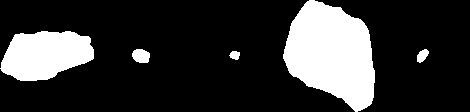

In [224]:
Images.mosaicview([Gray.(props[1][idx, :mask]) for idx in range(1,5)], nrow=1)

and for the second:

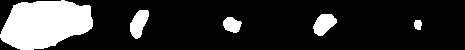

In [225]:
Images.mosaicview([Gray.(props[2][idx, :mask]) for idx in range(1,5)], nrow=1)

Using the `Plots` library we can see how the ψ-s curves differ between floes. We plot 20 of the floes in each image first, with gray and orange, then highlight two floes in particular with the darker lines where we know that the floes are a match.

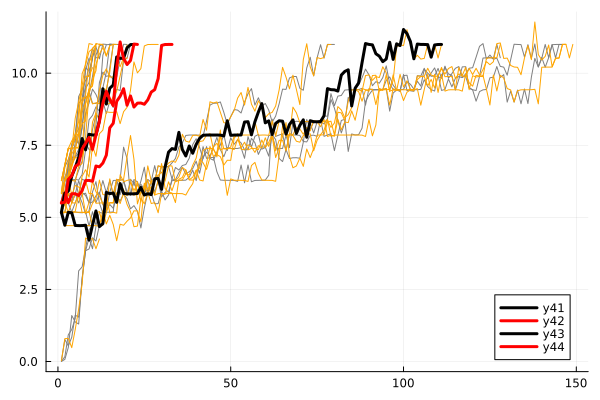

In [226]:
using Plots
plot([props[1][idx, :psi] for idx in range(1,20)], lc=:gray, linewidth=1, label=false)
plot!([props[2][idx, :psi] for idx in range(1,20)], lc=:orange, linewidth=1, label=false)
plot!(props[1][1,:psi], lc=:black, linewidth=3)
plot!(props[2][2, :psi], lc=:red, linewidth=3)
plot!(props[1][2,:psi], lc=:black, linewidth=3)
plot!(props[2][3, :psi], lc=:red, linewidth=3)

# Tracking

With the table sufficiently populated, we can now run the tracker. We can see the arguments needed by using the `@doc` macro.


In [227]:
track_results = IceFloeTracker.long_tracker(props, ct, mc_thresholds);

┌ Warning: time difference too small for a large rotation or mismatch too large
│ mm: 0.28 (threshold 0.22), rot: 9.0 (threshold 10)
└ @ IceFloeTracker /Users/dwatkin2/Documents/research/packages/IceFloeTracker.jl/src/tracker/matchcorr.jl:88
┌ Warning: time difference too small for a large rotation or mismatch too large
│ mm: 0.278 (threshold 0.22), rot: -10.0 (threshold 10)
└ @ IceFloeTracker /Users/dwatkin2/Documents/research/packages/IceFloeTracker.jl/src/tracker/matchcorr.jl:88
┌ Warning: correlation too low, r: 0.855
└ @ IceFloeTracker /Users/dwatkin2/Documents/research/packages/IceFloeTracker.jl/src/tracker/matchcorr.jl:71
┌ Warning: time difference too small for a large rotation or mismatch too large
│ mm: 0.335 (threshold 0.22), rot: 7.0 (threshold 10)
└ @ IceFloeTracker /Users/dwatkin2/Documents/research/packages/IceFloeTracker.jl/src/tracker/matchcorr.jl:88
┌ Warning: time difference too small for a large rotation or mismatch too large
│ mm: 0.34 (threshold 0.22), rot: -10.0 

The settings for the tracker are organized into two categories: condition thresholds and match-correlation thresholds. We'll use the default values for each in this example.

In [17]:
names(track_results)

21-element Vector{String}:
 "ID"
 "trajectory_uuid"
 "head_uuid"
 "uuid"
 "area"
 "min_row"
 "min_col"
 "max_row"
 "max_col"
 "row_centroid"
 ⋮
 "major_axis_length"
 "minor_axis_length"
 "orientation"
 "perimeter"
 "mask"
 "passtime"
 "psi"
 "area_mismatch"
 "corr"

In [228]:
track_results[!, ["trajectory_uuid", "uuid", "area", "area_mismatch", "corr"]]

Row,trajectory_uuid,uuid,area,area_mismatch,corr
,String,String,Float64,Float64?,Float64?
1,0KvWEZXXq6qI,IkKerPCsLe4e,7116.0,missing,missing
2,0KvWEZXXq6qI,dkdO2Ebs4Wp7,7006.0,0.031,0.991
3,3pfOt7qvnW8S,9z2qFJHSl2jA,461.0,missing,missing
4,3pfOt7qvnW8S,YRodve3OVaYj,476.0,0.066,0.993
5,6OqhWbflsK3q,MLLTzFCJ1MpV,4428.0,missing,missing
6,6OqhWbflsK3q,jAWYUZkZuKD5,4524.0,0.047,0.993
7,Cjl09rEdFoy2,jnBtZKpcEXdI,1282.0,missing,missing
8,Cjl09rEdFoy2,PUhQBOZxtIdS,1312.0,0.081,0.999
9,EprqFVAt9XC7,IIsFijS6gIdk,1234.0,missing,missing


As you can see each of these is a named tuple with multiple parameters. The search thresholds estimate the maximum travel distance as a function of elapsed time. We divide the settings between small and large floes, with the motivation that uncertainty in shape properties depends on the size of the object relative to the size of the pixels. So we tend to have more lenient settings for the small floes than for the large floes.

In [229]:
props[1][!, :bdry] = IceFloeTracker.bwtraceboundary.(props[1][!, :mask])
props[2][!, :bdry] = IceFloeTracker.bwtraceboundary.(props[2][!, :mask]);

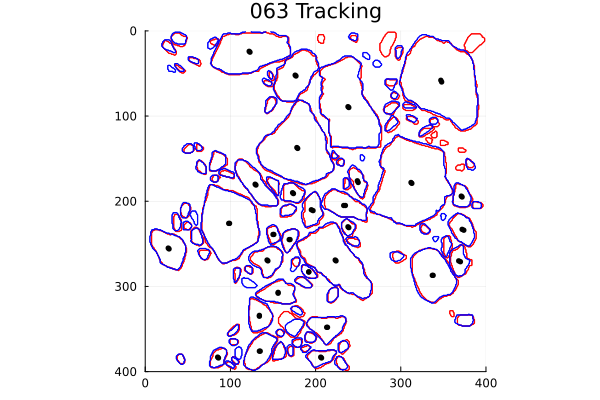

In [230]:
plt = Plots.contour(aqua.validated_binary_floes .> 0, levels=2, color=:red, label="Aqua", legend=false, aspect_ratio=:equal)
Plots.contour!(terra.validated_binary_floes .> 0, levels=2, color=:blue, label="Terra")
for traj_id in unique(track_results.trajectory_uuid)
    traj_data = filter(r -> r.trajectory_uuid == traj_id, track_results);
    plot!(traj_data.col_centroid, traj_data.row_centroid, marker=:circle, markersize=3, color=:black, linewidth=1)
    # Plots.scatter!(ax1, first(traj_data.col_centroid), first(traj_data.row_centroid), marker=:circle, markersize=5, color=:blue)
    # Plots.scatter!(ax1, last(traj_data.col_centroid), last(traj_data.row_centroid), marker=:rect, markersize=5, color=:red)
end
ylims!(0, 400)
xlims!(0, 400)
yflip!(true)
title!(split(aqua.name, "-")[1]*" Tracking")
plt

Understanding non-tracked floes. Are they just non-unique? Or is the fit poor?

In [267]:
filter(r -> r.row_centroid > 300, track_results)[!, ["row_centroid", "col_centroid", "trajectory_uuid", "area"]]

Row,row_centroid,col_centroid,trajectory_uuid,area
,Int64,Int64,String,Float64
1,376,134,Hf7xkklQQLFW,1065.0
2,376,135,Hf7xkklQQLFW,1068.0
3,383,206,MmA0vU0BVHOB,482.0
4,384,207,MmA0vU0BVHOB,494.0
5,334,134,Q1Txo1litXNg,852.0
6,335,134,Q1Txo1litXNg,806.0
7,307,156,W0LnPBLuqlDW,929.0
8,308,156,W0LnPBLuqlDW,878.0
9,348,213,fleUbiJB2xtH,953.0


From this result, we see that a handful of the floes are tracked correctly, one floe has incorrect tracking, and many floes are untracked. Whether floes are tracked depends on the uniqueness of the shape and the floe size. For example, minimum floe size is a user specified parameter. Using one of the matched floes, let's look at how we estimate uncertainty in the rotation estimate.

In [231]:

unique(track_results.trajectory_uuid[1:end])

29-element Vector{String}:
 "0KvWEZXXq6qI"
 "3pfOt7qvnW8S"
 "6OqhWbflsK3q"
 "Cjl09rEdFoy2"
 "EprqFVAt9XC7"
 "Hf7xkklQQLFW"
 "I7GEU5DXwHKL"
 "JibidKpD9Ju5"
 "KVTOnAIhAbZj"
 "KwW95EDExTvm"
 ⋮
 "gDozhLVR8DXV"
 "gYnv46OPTCBE"
 "hrlhO6QrUqdu"
 "j7M06j6uNj4e"
 "kukGpWZgmfSa"
 "pJvVkORJ5S0n"
 "qWDKU4zVbc2z"
 "tmluQOfJ8LbX"
 "yS5Do0bQ1AYU"

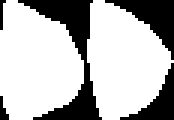

In [268]:
traj_id = "Q1Txo1litXNg" # another floe
traj_data = filter(r -> r.trajectory_uuid == traj_id, track_results)

floe1 = first(traj_data)
floe2 = last(traj_data)
mosaicview(Gray.(floe1.mask), Gray.(floe2.mask), nrow=1)

In [238]:
percentile(normed_sd, 5)

0.05681031016300042

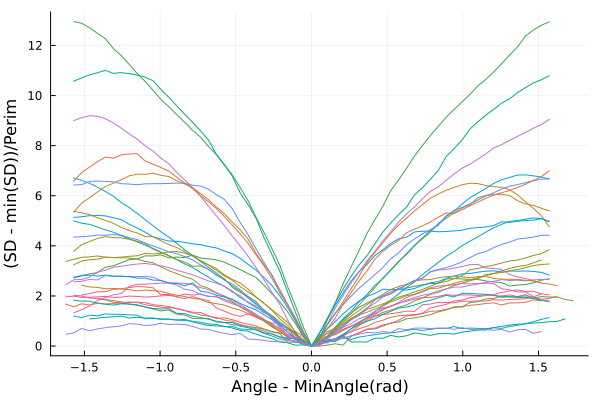

In [263]:
using StatsBase
using Interpolations

plt = plot(label=false)
for traj_id in unique(track_results.trajectory_uuid)
    traj_data = filter(r -> r.trajectory_uuid == traj_id, track_results)

    floe1 = first(traj_data)
    floe2 = last(traj_data)

    precision = π / 60
    results = IceFloeTracker.shape_difference_rotation(floe1.mask, floe2.mask, collect(range(; start=-π/2, stop=π/2, step=precision)))
    angle = first.(results)
    shape_difference = last.(results)
    idx = sortperm(angle)
    angle .= angle[idx]
    shape_difference .= shape_difference[idx]
    min_angle = angle[argmin(shape_difference)]
    mean_perimeter = mean([floe1.perimeter, floe2.perimeter])
    normed_sd = (shape_difference .- minimum(shape_difference))./ mean_perimeter
    # normed_sd_threshold = 0 # percentile(normed_sd, 10)
    # interp_fun = LinearInterpolation(angle, normed_sd .- normed_sd_threshold);


    # Show the shape difference
    plot!(angle .- min_angle, normed_sd, legend=false, ylabel="(SD - min(SD))/Perim", xlabel="Angle - MinAngle(rad)")
end
plt

In [235]:
fitted_range

(-1.5707963267948966, 1.5707963267948966)

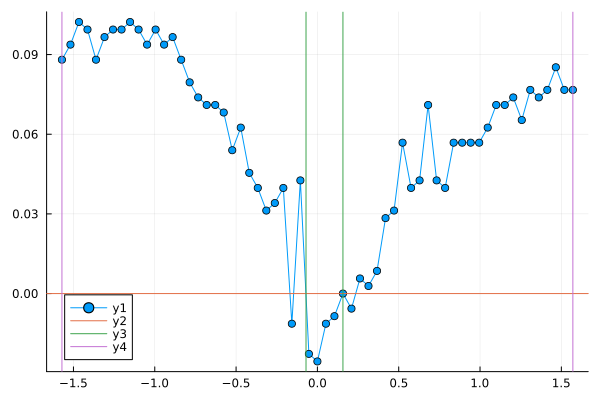

In [236]:
# TODO: set test for situation when test range would require extrapolation
# e.g., could force the range to be within -pi and pi.

register_angle = angle[argmin(shape_difference)];
precision = π / 180
test_range = π / 2 # Will search for roots within +/- π/2 of the minimum angle
fitted_range = (minimum(angle), maximum(angle))
test_left = range(; start=maximum([register_angle - test_range, fitted_range[1]]), stop=register_angle, step=precision)
test_right = range(; start=register_angle, stop=minimum([register_angle + test_range, fitted_range[2]]), step=precision) 

left = argmin(abs.(interp_fun(test_left)))
right = argmin(abs.(interp_fun(test_right)))
angle_ci = (test_left[left], test_right[right])
angle_ci = round.(angle_ci, digits=3)

plot(angle, interp_fun(angle), marker=:circle)
hline!([0])
vline!([angle_ci[1], angle_ci[2]])
vline!([minimum(test_left), maximum(test_right)])

In [185]:
round.(angle_ci, digits=3)

(1.326, 1.815)

In [186]:
# if the shape difference is never less than one, then we reject the rotation fit.
# if there are multiple minima, we need to report that somehow

rad2deg.(angle_ci)

(75.97420363434716, 103.99183981624441)

In [187]:
rad2deg.(angle_ci)[2] - rad2deg.(angle_ci)[1]

28.017636181897245